In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import pretty_midi
import matplotlib.pyplot as plt
import random
from mido import Message, MidiFile, MidiTrack

In [2]:
def load_piano_rolls(directory_path):
    piano_lists = []
    max_len = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(".mid"):
            file_path = os.path.join(directory_path, filename)
            mid = pretty_midi.PrettyMIDI(file_path)
            piano_roll = mid.get_piano_roll(fs=5)
            max_len = max(max_len, piano_roll.shape[1]) #max_len es usada para conocer el piano roll mas grande
            piano_roll = piano_roll[21:98] #21 - 98 es el rango de notas audibles de la guitarra, PianoRoll original va de 0 - 127
            piano_roll[piano_roll > 0] = 1
            piano_lists.append(piano_roll)
    return piano_lists, max_len

#Función para obtener los Piano Rolls de cada midi, dependiendo la carpeta
list_of_piano_rolls, max_len = load_piano_rolls("Guitarras y bajos//Bajos//")

C:\Users\under\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [3]:
def padNotes(sequence, maxlen, roll_len, pad_value): #Padding para obtener todos los Piano Rolls del mismo tamaño
    paddedRoll = np.zeros((77, maxlen))
    paddedRoll[:] = pad_value
    paddedRoll[:, -roll_len:] = sequence
    return paddedRoll.transpose()

class MusicDataset(Dataset):
    def __init__(self, tensor_list, maxlen):
        self.data = tensor_list
        self.max_len = maxlen

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        piano_roll = self.data[idx]
        sequence_len = piano_roll.shape[1] -1
        input_sequence = piano_roll[:, :-1] #La secuencia de entrada es el piano roll menos la última nota
        target_sequence = piano_roll[:, 1:] #La secuencia esperada de salida es todo el piano roll menos la primer nota
        #Es decir se espera que la salida de una nota sea la siguiente de la secuencia original

        input_sequence = padNotes(input_sequence, self.max_len, sequence_len, 0)
        target_sequence = padNotes(target_sequence, self.max_len, sequence_len, -100)
        
        return (torch.FloatTensor(input_sequence), torch.LongTensor(target_sequence), torch.LongTensor([sequence_len]))


In [4]:
indexes = list(range(len(list_of_piano_rolls))) #lista de 0 a n donde n representa la cantidad de archivos midi
random.shuffle(indexes) #se mezclan para que la muestra sea aleatoria

validation_len = int(len(list_of_piano_rolls)*0.8) #se toma el 80% para entrenamiento y el 20% para validación
index_train = indexes[:validation_len]
index_validation = indexes[validation_len:]

train_tensors = [list_of_piano_rolls[i] for i in index_train]
validation_tensors= [list_of_piano_rolls[i] for i in index_validation]

train_dataset = MusicDataset(train_tensors, max_len)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True) 
#Se crea un lote de 5 tuplas que contienen (InputTensor, OutputTensor, SequenceLen) cada una

validation_dataset = MusicDataset(validation_tensors, max_len)
validation_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, drop_last=True)
#Se crea un lote de 3 tuplas que contienen (InputTensor, OutputTensor, SequenceLen) cada una

In [2]:
class MusicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, number_cells, layers):
        super(MusicLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_cells = number_cells
        self.layers = layers

        self.linear = nn.Linear(input_size, hidden_size)
        self.normal = nn.BatchNorm1d(hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, layers)
        self.linear2 = nn.Linear(hidden_size, number_cells)

    def forward(self, input_sequence, input_sequence_lens, hidden=None):
        
        output = self.linear(input_sequence)
        output = output.permute(1,2,0).contiguous()
        
        output = self.normal(output)
        output = nn.Dropout(0.25)(output)
        output = output.permute(2,0,1)
        
        output_packed = torch.nn.utils.rnn.pack_padded_sequence(output, input_sequence_lens)
        output, hidden = self.lstm(output_packed, hidden)

        output, output_lens = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = output.permute(1,2,0).contiguous()
        output = self.normal(output)
        output = nn.Dropout(0.1)(output)

        output = output.permute(2,0,1)
        logits = self.linear2(output)
        logits = logits.transpose(0,1).contiguous()

        rev_lgts = (1 - logits)

        zero_one_logits = torch.stack((logits, rev_lgts), dim=3).contiguous()
        flatten_logits = zero_one_logits.view(-1,2)

        return flatten_logits, hidden

In [6]:
def orderTensors(batch):

    input_sequences, output_sequences, lens = batch

    input_sequences = input_sequences.split(split_size=1)
    output_sequences = output_sequences.split(split_size=1)
    lens = lens.split(split_size=1)

    train_data_tuples = zip(input_sequences, output_sequences, lens)
    train_data_tuples = sorted(train_data_tuples,key=lambda c: int(c[2]),reverse=True)

    input_sequences, output_sequences, lens = zip(*train_data_tuples)
    
    ordered_inputs = torch.cat(input_sequences)
    ordered_outputs = torch.cat(output_sequences)
    ordered_lens = torch.cat(lens)
        
    ordered_inputs = ordered_inputs[:, -ordered_lens[0, 0]:, :]
    ordered_outputs = ordered_outputs[:, -ordered_lens[0, 0]:, :]    
    ordered_inputs = ordered_inputs.transpose(0, 1)

    ordered_lens_list = list(ordered_lens)
    ordered_lens_list = map(lambda k: int(k), ordered_lens_list)

    return ordered_inputs.cuda(), ordered_outputs.contiguous().view(-1).cuda(), list(ordered_lens_list)

In [17]:
input_size = 77
hidden_size = 512
number_cells = 77
layers = 3

model = MusicLSTM(input_size, hidden_size, number_cells, layers).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
train_losses = []
validation_losses = []

for epoch in range(1, num_epochs+1):

    #Training Loop
    model.train()
    for batch in train_dataloader:

        input_sequence, output_sequence, sequence_len = orderTensors(batch)
        optimizer.zero_grad()

        output, _ = model(input_sequence, sequence_len)
        train_loss = criterion(output, output_sequence)

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(train_loss.item())

    #Evaluation Loop
    model.eval()
    val_loss_full = 0.0
    seq_len = 0.0
    for batch in validation_dataloader:
        val_inputs, val_outputs, seq_lens = orderTensors(batch)
        output, _ = model(val_inputs, seq_lens)
        loss = criterion(output, val_outputs)
        val_loss_full += loss.item()
        seq_len += sum(seq_lens)   
        
    validation_loss = val_loss_full/(seq_len*37)
    validation_losses.append(validation_loss)
        
    if ((epoch) % 1 == 0):
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss.item()}, Validation Loss: {validation_loss}')


Epoch [1/20], Train Loss: 0.06538217514753342, Validation Loss: 5.418933952655767e-07
Epoch [2/20], Train Loss: 0.06553447991609573, Validation Loss: 5.105052581551119e-07
Epoch [3/20], Train Loss: 0.035510506480932236, Validation Loss: 5.006624868602751e-07
Epoch [4/20], Train Loss: 0.05322509631514549, Validation Loss: 4.7162149055910436e-07
Epoch [5/20], Train Loss: 0.038239266723394394, Validation Loss: 5.07307514470544e-07
Epoch [6/20], Train Loss: 0.0509316548705101, Validation Loss: 4.521484882433833e-07
Epoch [7/20], Train Loss: 0.0430070199072361, Validation Loss: 4.5776093483197047e-07
Epoch [8/20], Train Loss: 0.04895154759287834, Validation Loss: 4.479280418611305e-07
Epoch [9/20], Train Loss: 0.04507290944457054, Validation Loss: 5.698255779971304e-07
Epoch [10/20], Train Loss: 0.04051307216286659, Validation Loss: 4.686436097248833e-07
Epoch [11/20], Train Loss: 0.07293948531150818, Validation Loss: 5.523123853372813e-07
Epoch [12/20], Train Loss: 0.05097266659140587, Val

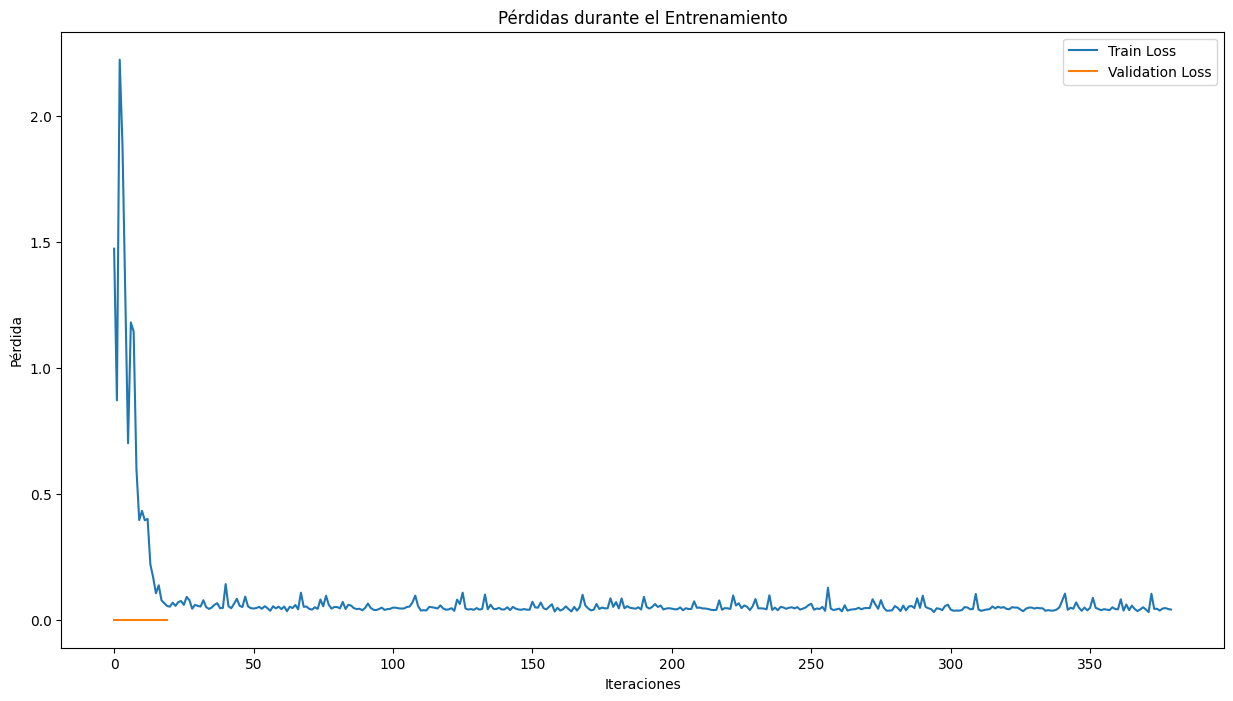

In [18]:
# Graficar las pérdidas
plt.figure(figsize=(15, 8))
plt.title('Pérdidas durante el Entrenamiento')
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [35]:
#Descomentar si se desa guardar el estado de la red
#torch.save(model.state_dict(), 'lstm_bass.pth')